# Sports Image Classification

This notebook trains a simple CNN to classify sports images into 100 categories.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [3]:
# Configuration
BATCH_SIZE = 32
DATA_DIR = 'data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DIR = os.path.join(DATA_DIR, 'test')
IMG_SIZE = (224, 224)

# Check if directories exist
print(f"Train dir: {os.path.exists(TRAIN_DIR)}")
print(f"Valid dir: {os.path.exists(VALID_DIR)}")
print(f"Test dir: {os.path.exists(TEST_DIR)}")

Train dir: True
Valid dir: True
Test dir: True


In [4]:
# Load Datasets
print("Loading Training Data...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("Loading Validation Data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Loading Test Data...")
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print(f"Class names: {class_names[:5]} ... (total {len(class_names)})")
num_classes = len(class_names)

Loading Training Data...
Found 13492 files belonging to 100 classes.
Loading Validation Data...
Found 500 files belonging to 100 classes.
Loading Test Data...
Found 500 files belonging to 100 classes.
Class names: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing'] ... (total 100)


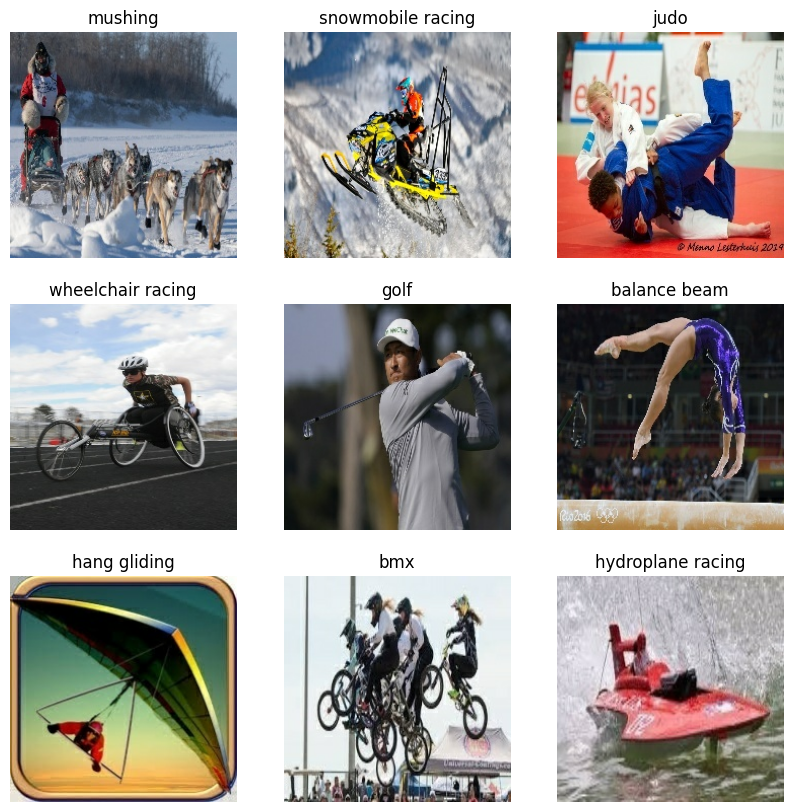

In [5]:
# Visualize some data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Performance optimization
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Model Architecture
model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

c:\Users\ethan\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,809,316 (98.45 MB)

 Trainable params: 25,809,316 (98.45 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
# Train
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 150s 346ms/step - accuracy: 0.0386 - loss: 4.3801 - val_accuracy: 0.1080 - val_loss: 3.9485
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 131s 311ms/step - accuracy: 0.1611 - loss: 3.5440 - val_accuracy: 0.2880 - val_loss: 3.0127
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 138s 327ms/step - accuracy: 0.2974 - loss: 2.8006 - val_accuracy: 0.3380 - val_loss: 2.6244
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 133s 314ms/step - accuracy: 0.4235 - loss: 2.1899 - val_accuracy: 0.3620 - val_loss: 2.5494
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 133s 315ms/step - accuracy: 0.5457 - loss: 1.6668 - val_accuracy: 0.3360 - val_loss: 2.7072
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 134s 317ms/step - accuracy: 0.6408 - loss: 1.2784 - val_accuracy: 0.3640 - val_loss: 2.8478
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 130s 309ms/step - accuracy: 0.7092 - loss: 1.0269 - val_accuracy: 0.3360 - val_loss: 2.8471
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 133s 315ms/step - accuracy: 0.7623 -

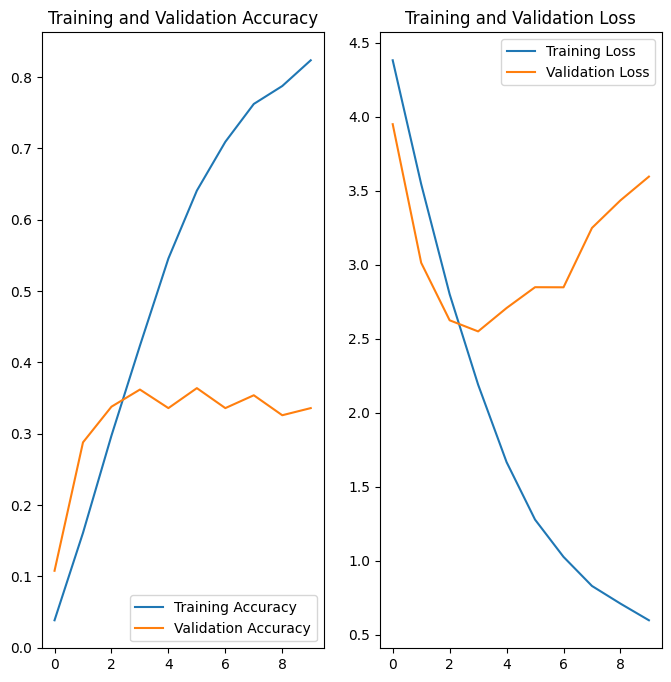

In [10]:
# Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# Evaluate
print("Evaluating on test set...")
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

Evaluating on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3660 - loss: 3.1964
Test Loss: 3.1963741779327393
Test Accuracy: 0.3659999966621399
